In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

# Let's make a Neural Network! ~~
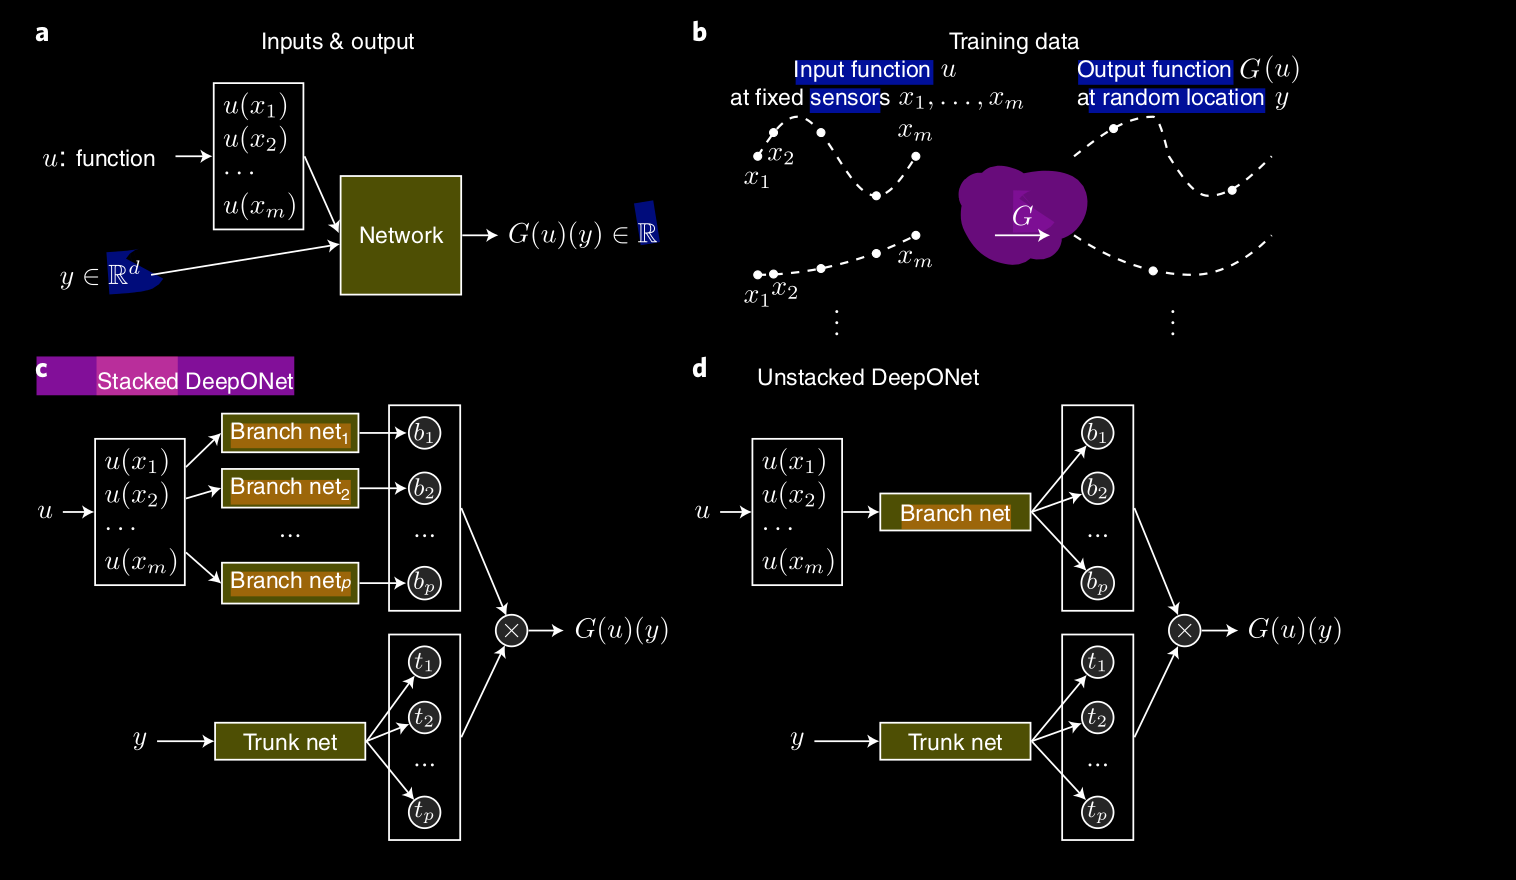

In [2]:
class StackedBranchNet(nn.Module):
    def __init__(self, num_sensors, num_hidden, hidden_size, output_size):
        '''
        num_sensors - we decide in m fixed values of x to sample from different u(x)s
        Here all these inputs share a common set of parameters
        
        '''
        super(StackedBranchNet, self).__init__()
        
        self.input_size = num_sensors
        self.num_hidden = num_hidden
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # NN Architecture ~~
        
        self.input_fc = nn.Linear(self.input_size, hidden_size)
        
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            hfc = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(hfc)
        
        self.output_fc = nn.Linear(hidden_size, output_size)
        
        # Activation is just LeakyReLU for now
        self.activation = nn.LeakyReLU()
        
        
    def forward(self, x):
        out = self.input_fc(x)
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        out = self.output_fc(out)
        return out
    
    
class TrunkNet(nn.Module):
    def __init__(self, num_hidden, hidden_size, output_size):
        super(TrunkNet, self).__init__()
        
        self.num_hidden = num_hidden
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # ~~ NN Architecture ~~
        
        self.input_fc = nn.Linear(1, hidden_size)
        
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            hfc = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(hfc)
        
        self.output_fc = nn.Linear(hidden_size, output_size)
        
        # Activation is just LeakyReLU for now
        self.activation = nn.LeakyReLU()
        
        
    def forward(self, x):
        out = self.input_fc(x)
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        out = self.output_fc(out)
        return out     
   
class YoOpNet(nn.Module):
    def __init__(self, 
                 num_sensors = 100, 
                 num_hidden_branch = 1, 
                 hidden_size_branch = 50, 
                 output_size_branch = 30, 
                 num_hidden_trunk = 1, 
                 hidden_size_trunk = 30, 
                 output_size_trunk = 30 
            ):
        super(YoOpNet, self).__init__()        
        
        self.branch_net = StackedBranchNet(num_sensors, num_hidden_branch, hidden_size_branch, output_size_branch)
        self.trunk_net = TrunkNet(num_hidden_trunk, hidden_size_trunk, output_size_trunk)
        
        self.combined_fc = nn.Linear(output_size_branch + output_size_trunk, 1)
    
    def forward(self, x_branch, x_trunk):
        # if x_branch.dim() == 1:
        #     x_branch = x_branch.unsqueeze(0)  # Ensure it's 2D (1, num_features)
        # else:
        #     x_branch = x_branch.t() if x_branch.shape[0] != self.branch_net.input_size else x_branch

        out_branch = self.branch_net(x_branch)
        out_trunk = self.trunk_net(x_trunk.unsqueeze(1))
        combined = torch.cat((out_branch, out_trunk), dim=1)
        out = self.combined_fc(combined)
        return out    

# But what about the data ¯\\_(ツ)_/¯

1. We need to generate triplets of (u, y, G(u)(y)) where:
    - u is a function of x - we sample u(x) values from the sensor positions
    - G(u) is the anti-derivative of u
    - y is in the domain to G(u)

2. Let's start with a bunch of functions that will be G(u)...
    We will get u(x) by differentiating these functions
    - Let's just do cubic polynomials for now

3. Now we have the following
    - A set of u(x) and G(u)(x) function coefficients
    - A set of sensor locations to query each u(x) at
    - A set of x_trunk locations to query G(u)(x_trunk) for each u(x)

4. Following diagram highlights the dataset...

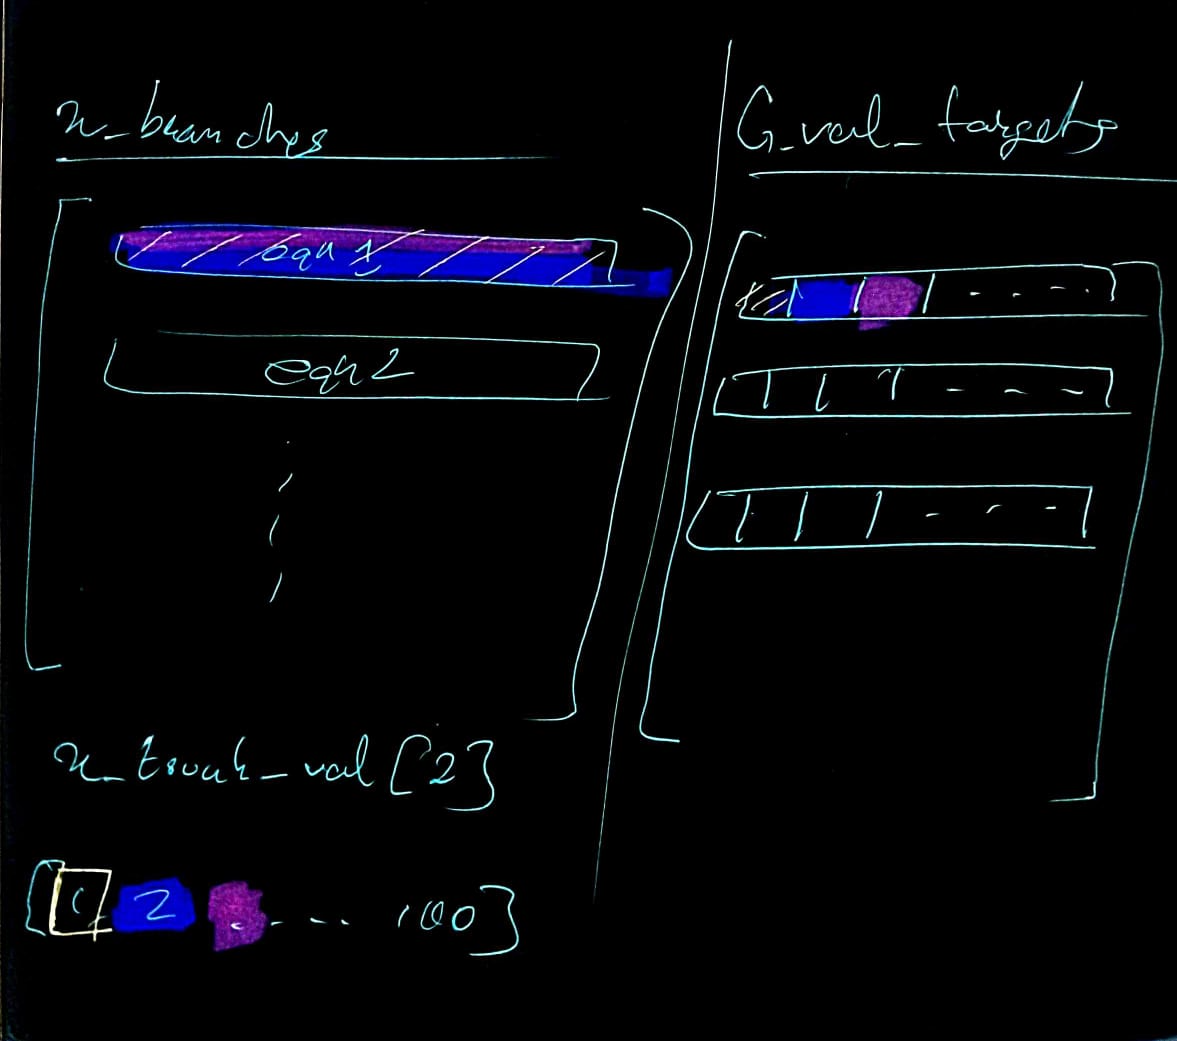

- for idx...
    - x_branch = x_branches[idx // len(x_trunk_val[2])]
    - x_trunk = x_trunk_val[2][idx % len(x_trunk_val[2])]
    - target = G_value_targets[idx // len(x_trunk_val[2])][idx % len(x_trunk_val[2])]

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split

class CubicPolynomialDataset(Dataset):
    def __init__(self):
        super().__init__()
        
        # Let's start by generating a bunch of random cubic polynomials coeffs and that of their derivatives
        domain_limits = [-100, 101]
        sampling_window = 10
        how_many_in_a_window = 20
        self.Ga = np.concatenate([np.random.randint(low, low+sampling_window+1, how_many_in_a_window) for low in range(domain_limits[0], domain_limits[1], sampling_window)])
        self.Gb = np.concatenate([np.random.randint(low, low+sampling_window+1, how_many_in_a_window) for low in range(domain_limits[0], domain_limits[1], sampling_window)])
        self.Gc = np.concatenate([np.random.randint(low, low+sampling_window+1, how_many_in_a_window) for low in range(domain_limits[0], domain_limits[1], sampling_window)])
        self.Gd = np.concatenate([np.random.randint(low, low+sampling_window+1, how_many_in_a_window) for low in range(domain_limits[0], domain_limits[1], sampling_window)])

        self.ua = 3*self.Ga
        self.ub = 2*self.Gb
        self.uc = self.Gc
        
        # Matrix of coefficients
        u_coeff_matrix = np.vstack((self.ua, self.ub, self.uc)).T
        G_coeff_matrix = np.vstack((self.Ga, self.Gb, self.Gc, self.Gd)).T

        # Sensor locations 
        self.num_sensors = 100
        self.x_sensor_locations = np.linspace(domain_limits[0], domain_limits[1], self.num_sensors)
        
        # x_trunk locations
        self.num_x_trunk_for_each_u = 100
        self.x_trunk_locations = np.linspace(domain_limits[0], domain_limits[1], self.num_x_trunk_for_each_u)
        
        # Matrix of variables
        self.x_branch_variable_matrix = np.vstack((self.x_sensor_locations**2,
                                              self.x_sensor_locations,
                                              np.ones((1, self.num_sensors))
                                            ))
        
        self.x_trunk_variable_matrix = np.vstack((self.x_trunk_locations**3,
                                             self.x_trunk_locations**2,
                                             self.x_trunk_locations,
                                             np.ones((1, self.num_x_trunk_for_each_u))
                                            )) 
        
        
        # Input / Output Matrices ~~
        
        self.x_branches = np.dot(u_coeff_matrix, self.x_branch_variable_matrix)  
        # each row here is a set of sensor point values for one function u  # we have a row for each of the polynomials we generated
        
        self.G_value_targets = np.dot(G_coeff_matrix, self.x_trunk_variable_matrix)
        # each row here is a series of target values for each x_trunk corresponding to one function G(u)
        
        
        # testing shapes
        # print(self.Ga.shape)
        # print(self.x_sensor_locations.shape)
        # print(self.x_branches.shape)
        # print(self.G_value_targets.shape)
        
        
    def __len__(self):
        return self.num_x_trunk_for_each_u * len(self.Ga)

    def __getitem__(self, idx):
        
        row = idx // self.num_x_trunk_for_each_u
        col = idx % self.num_x_trunk_for_each_u
        
        x_branch = self.x_branches[row]
        x_trunk = self.x_trunk_variable_matrix[2][col]
        
        target = self.G_value_targets[row][col]
        
        return torch.tensor(x_branch, dtype=torch.float32), torch.tensor(x_trunk, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)
    

#### TODO:
    - Normalize the data

# Now we train, save and evaluate ~~ 

In [4]:
!pip install wandb

In [5]:
import wandb
from tqdm.auto import tqdm
from sklearn.metrics import r2_score

In [6]:
# batch_size = 64
# learning_rate = 0.01
# num_epochs = 100

# train_percentage = 0.8

# dataset = CubicPolynomialDataset()
# train_dataset, test_dataset = random_split(dataset, [int(train_percentage*len(dataset)), len(dataset) - int(train_percentage*len(dataset))])

# train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# model = YoOpNet()

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)
# print(device)

In [7]:
config = {
    "batch_size": 64,
    "learning_rate": 0.01,
    "num_epochs": 5,
    "train_percentage": 0.8,
    "criteria": "nn.MSELoss()",
    "optim": "Adam"
}


In [8]:
def model_pipeline(hyperparameters):
    
    with wandb.init(project="yoopnet", config=hyperparameters):
        config = wandb.config

        # ~~ Make the Model & dataloaders ~~
        dataset = CubicPolynomialDataset()
        train_dataset, test_dataset = random_split(dataset, [int(config.train_percentage*len(dataset)), len(dataset) - int(config.train_percentage*len(dataset))])
        train_data_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        test_data_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=True)
        
        
        model = YoOpNet()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr = config.learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.lr_decay_step, gamma=config.lr_decay)
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
        print(device)
        
        # ~~ Training  Loop ~~
        wandb.watch(model, criterion, log="all", log_freq=10)
        
        for epoch in range(config.num_epochs):
            
            # ~~ Training ~~
            model.train()
            train_loss = 0
            train_targets, train_outputs = [], []
            
            for x_branch, x_trunk, target in train_data_loader:
                x_branch, x_trunk, target = x_branch.to(device), x_trunk.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(x_branch, x_trunk)
                loss = criterion(output, target.unsqueeze(1))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item() 
                train_targets.extend(target.cpu().numpy())
                train_outputs.extend(output.cpu().detach().numpy())
            
            scheduler.step()
            
            train_loss /= len(train_data_loader)
            train_r2 = calculate_r2(np.array(train_outputs), np.array(train_targets))
            
            
            
            # ~~ Validation ~~
            model.eval()
            val_loss = 0
            val_targets, val_outputs = [], []
            
            with torch.no_grad():
                for x_branch, x_trunk, target in test_data_loader:
                    x_branch, x_trunk, target = x_branch.to(device), x_trunk.to(device), target.to(device)
                    output = model(x_branch, x_trunk)
                    loss = criterion(output, target.unsqueeze(1))
                    
                    val_loss += loss.item()
                    val_targets.extend(target.cpu().numpy())
                    val_outputs.extend(output.cpu().detach().numpy())
                    
            val_loss /= len(test_data_loader)
            val_r2 = calculate_r2(np.array(val_outputs), np.array(val_targets))
            
            
            # ~~ Log metrics ~~
            
            wandb.log({
                "epoch": epoch,
                "learning_rate": scheduler.get_last_lr()[0],
                "train_loss": train_loss,
                "train_r2": train_r2,
                "val_loss": val_loss,
                "val_r2": val_r2
            })
            
            print(f"Epoch {epoch} - Train Loss: {train_loss}, Train r2: {train_r2}, Val Loss: {val_loss}, Val r2: {val_r2}")            
    
        # Save the model
        torch.save(model.state_dict(), "yoopnet.pth")
        wandb.save("yoopnet.pth")
    
    return model
    
def calculate_accuracy(output, target):
    return torch.mean(torch.abs(output - target))

def calculate_r2(output, target):
    return r2_score(np.array(target), np.array(output))
            
        
# config = {
#     "batch_size": 64,
#     "learning_rate": 0.01,
#     "num_epochs": 5,
#     "train_percentage": 0.8,
#     "criteria": "nn.MSELoss()",
#     "optim": "Adam"
# }

# model_pipeline(config)        
        
        
        

        

In [9]:
config = {
    "batch_size": 1024,
    "learning_rate": 0.01,
    "lr_decay": 0.90,
    "lr_decay_step": 40,
    "num_epochs": 1000,
    "train_percentage": 0.8,
    "criteria": "nn.MSELoss()",
    "optim": "Adam"
}
# young-thunder

model_pipeline(config)
# My wandb API key- 
#     f2c1707d4b66ab5a257ae02a99610adb23b2ced5

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


cuda:0
Epoch 0 - Train Loss: 570238197714323.4, Train r2: -0.0027180127604766735, Val Loss: 613355145279715.5, Val r2: 0.0005572182157945749
Epoch 1 - Train Loss: 568654920655592.8, Train r2: 0.00022964435475480993, Val Loss: 593057920232106.6, Val r2: 0.0011468144091156818
Epoch 2 - Train Loss: 568192123694235.1, Train r2: 0.0018033029966549874, Val Loss: 612431182983623.1, Val r2: 0.0037925471333165595
Epoch 3 - Train Loss: 566246261510516.4, Train r2: 0.005159034235189486, Val Loss: 615736533144917.4, Val r2: 0.005332823141484644
Epoch 4 - Train Loss: 564983403857361.5, Train r2: 0.006616280055558699, Val Loss: 597627687141376.0, Val r2: 0.004361075136227521
Epoch 5 - Train Loss: 566612683025563.1, Train r2: 0.0048441410364391535, Val Loss: 607624182511843.5, Val r2: 0.004704484230405925
Epoch 6 - Train Loss: 565327263575691.6, Train r2: 0.006632455834982287, Val Loss: 609279288424675.5, Val r2: 0.005361978042044413
Epoch 7 - Train Loss: 565314468152289.0, Train r2: 0.00619567538994

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▅▄█▅▄▆▆▅█▆▇▅▄▆▅▄▃▄▄▃▄▂▅▅▄▃▁▅▄▄▄▂▃▂▄▃▄▂▂▃
train_r2,▅▆▁▄▇▆▅▆▅▇▇▇▇█▆▇██▇█████████████████████
val_loss,▃▄▅▄▅▆▄▄▅▅▅▅▃▄▅█▅▄▅▅▃▄▆▃▃▆▄▃▄▄▅▁▅▃▆▅▄▄▂▃
val_r2,▅▇▃▁▄▅▃█▅▇▆▇▆█▆▇▇▇█▇▇▇█▇█▇▇█▇▇▇██▇█▇▇▇▇▇
epoch,999
train_loss,564999860781056.0
train_r2,0.00707
val_loss,610768814400398.2
val_r2,0.00535


YoOpNet(
  (branch_net): StackedBranchNet(
    (input_fc): Linear(in_features=100, out_features=50, bias=True)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=50, out_features=50, bias=True)
    )
    (output_fc): Linear(in_features=50, out_features=30, bias=True)
    (activation): LeakyReLU(negative_slope=0.01)
  )
  (trunk_net): TrunkNet(
    (input_fc): Linear(in_features=1, out_features=30, bias=True)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=30, out_features=30, bias=True)
    )
    (output_fc): Linear(in_features=30, out_features=30, bias=True)
    (activation): LeakyReLU(negative_slope=0.01)
  )
  (combined_fc): Linear(in_features=60, out_features=1, bias=True)
)